# Лабораторная работа №1
Выполнил: Шипилов К. Ю.
Группа: М8О-403Б-22

## Классификация

В качестве датасета выбран tawfikelmetwally/employee-dataset. Используя этот датасет можно обучить модель для выявления сотрудников, которые собираются покинуть компанию, и оценить влияние различных факторов на уход сотрудников из компании.

Импорт библиотек, функций и классов для подготовки данных, обучения и оценки моделей.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
)

Чтение датасета из файла.

In [2]:
df = pd.read_csv("./datasets/Employee.csv")
df.head()

,Education,JoiningYear,City,PaymentTier,Age,Gender,EverBenched,ExperienceInCurrentDomain,LeaveOrNot
0,Bachelors,2017,Bangalore,3,34,Male,No,0,0
1,Bachelors,2013,Pune,1,28,Female,No,3,1
2,Bachelors,2014,New Delhi,3,38,Female,No,2,0
3,Masters,2016,Bangalore,3,27,Male,No,5,1
4,Masters,2017,Pune,3,24,Male,Yes,2,1


Проверка типов признаков в датасете и наличия пропусков. 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4653 entries, 0 to 4652
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Education                  4653 non-null   object
 1   JoiningYear                4653 non-null   int64 
 2   City                       4653 non-null   object
 3   PaymentTier                4653 non-null   int64 
 4   Age                        4653 non-null   int64 
 5   Gender                     4653 non-null   object
 6   EverBenched                4653 non-null   object
 7   ExperienceInCurrentDomain  4653 non-null   int64 
 8   LeaveOrNot                 4653 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 327.3+ KB


Описание числовых признаков.

In [4]:
df.describe()

,JoiningYear,PaymentTier,Age,ExperienceInCurrentDomain,LeaveOrNot
count,4653.000000,4653.000000,4653.000000,4653.000000,4653.000000
mean,2015.062970,2.698259,29.393295,2.905652,0.343864
std,1.863377,0.561435,4.826087,1.558240,0.475047
min,2012.000000,1.000000,22.000000,0.000000,0.000000
25%,2013.000000,3.000000,26.000000,2.000000,0.000000
50%,2015.000000,3.000000,28.000000,3.000000,0.000000
75%,2017.000000,3.000000,32.000000,4.000000,1.000000
max,2018.000000,3.000000,41.000000,7.000000,1.000000


Распределение таргета.

In [5]:
target = "LeaveOrNot"
df["LeaveOrNot"].value_counts()

LeaveOrNot
0    3053
1    1600
Name: count, dtype: int64

Разделение выборки на тренировочную и тестовую с сохранением баланса таргета. Также определяются названия категориальных и численных признаков, для более удобной обработки данных.

In [6]:
y = df[target]
X = df.drop(columns=[target])

num_cols = ["JoiningYear", "Age", "ExperienceInCurrentDomain"]
cat_cols = ["Education", "City", "PaymentTier", "Gender", "EverBenched"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y
)

Функция оценки метрик классификации.

Главной метрикой выбрана ROC AUC, поскольку она оценивает качество ранжирования объектов по вероятности принадлежности к положительному классу. В отличие от метрик, зависящих от фиксированного порога (например, Accuracy или F1), ROC AUC агрегирует результаты по всем возможным порогам и показывает, насколько стабильно модель отделяет положительные объекты от отрицательных. 

In [7]:
def evaluate_classification(y_true, y_pred, y_proba):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred),
        "recall": recall_score(y_true, y_pred),
        "f1": f1_score(y_true, y_pred),
        "roc_auc": roc_auc_score(y_true, y_proba)
    }

### Бейзлайн

В качестве бейзлайна используется пайплайн, в котором к категориальным признакам применяется OrdinalEncoder (значения кодируются целыми неотрицательными числами), после чего применяется KNeghborsClassifier.

In [8]:
encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", "passthrough", num_cols)
])

base = Pipeline([
    ("preprocess", encoder),
    ("knn", KNeighborsClassifier())
])

base.fit(X_train, y_train)

y_pred = base.predict(X_test)
y_proba = base.predict_proba(X_test)[:, 1]

baseline_metrics = evaluate_classification(y_test, y_pred, y_proba)
baseline_metrics

{'accuracy': 0.7808807733619764,
 'precision': 0.7636363636363637,
 'recall': 0.525,
 'f1': 0.6222222222222222,
 'roc_auc': 0.7745064443535188}

Функция для отображения матрицы ошибок

In [9]:
def display_confusion_matrix(y_test, y_pred):
    con = confusion_matrix(y_test, y_pred)
    con_display = ConfusionMatrixDisplay(con)
    con_display.plot()
    plt.show()

Матрица ошибок

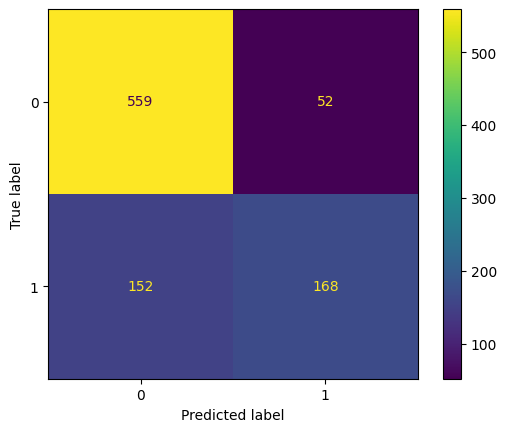

In [10]:
display_confusion_matrix(y_test, y_pred)

### Улучшение бейзлайна

Для начала закодируем категориальные признаки с помощью One Hot Encoder. Также первое значение признака отбрасывается, так как его можно выразить через остальные. Выведем полученный датасет.

In [11]:
encoder = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first"), cat_cols),
    ("num", "passthrough", num_cols)
])

X_train_enc = encoder.fit_transform(X_train)

ohe = encoder.named_transformers_["cat"]
ohe_cols = ohe.get_feature_names_out(cat_cols)
all_cols = list(ohe_cols) + num_cols

df_plot = pd.DataFrame(X_train_enc, columns=all_cols, index=X_train.index)
df_plot[target] = y_train
df_plot.head()

,Education_Masters,Education_PHD,City_New Delhi,City_Pune,PaymentTier_2,PaymentTier_3,Gender_Male,EverBenched_Yes,JoiningYear,Age,ExperienceInCurrentDomain,LeaveOrNot
2769,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2016.0,26.0,4.0,0
4269,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,2014.0,26.0,4.0,0
515,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,2016.0,24.0,2.0,0
50,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,2017.0,34.0,2.0,0
3072,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,2017.0,35.0,2.0,0


Построим матрицу корреляций признаков и таргета. На графике видно, что большая часть признаков имеет слабую корреляцию с таргетом, и есть признаки с корреляцией близкой к нулю.

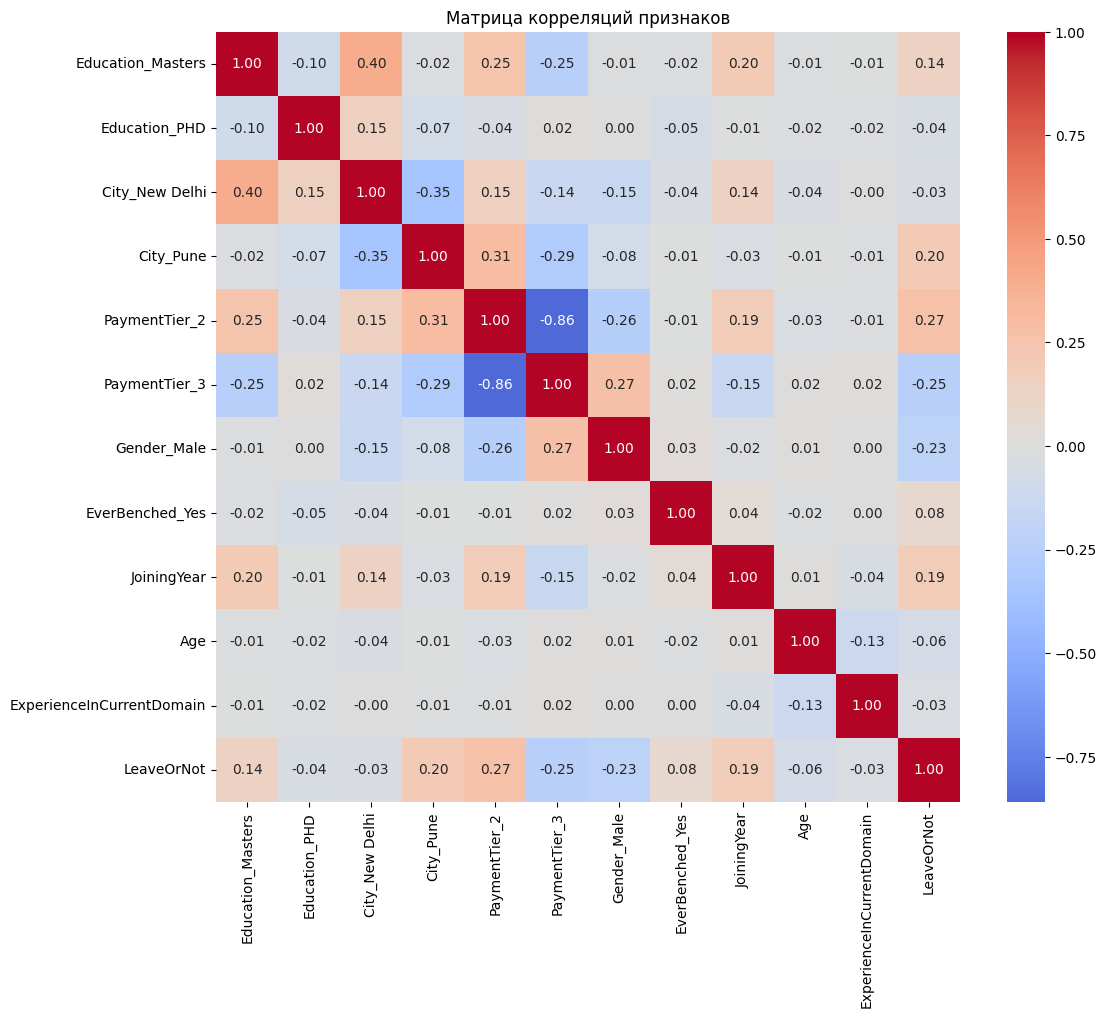

In [12]:
corr = df_plot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Матрица корреляций признаков")
plt.show()

Построим графики распределения признаков и парные scatter-графики. Разными цветами на графике обозначаются различные значения таргета.

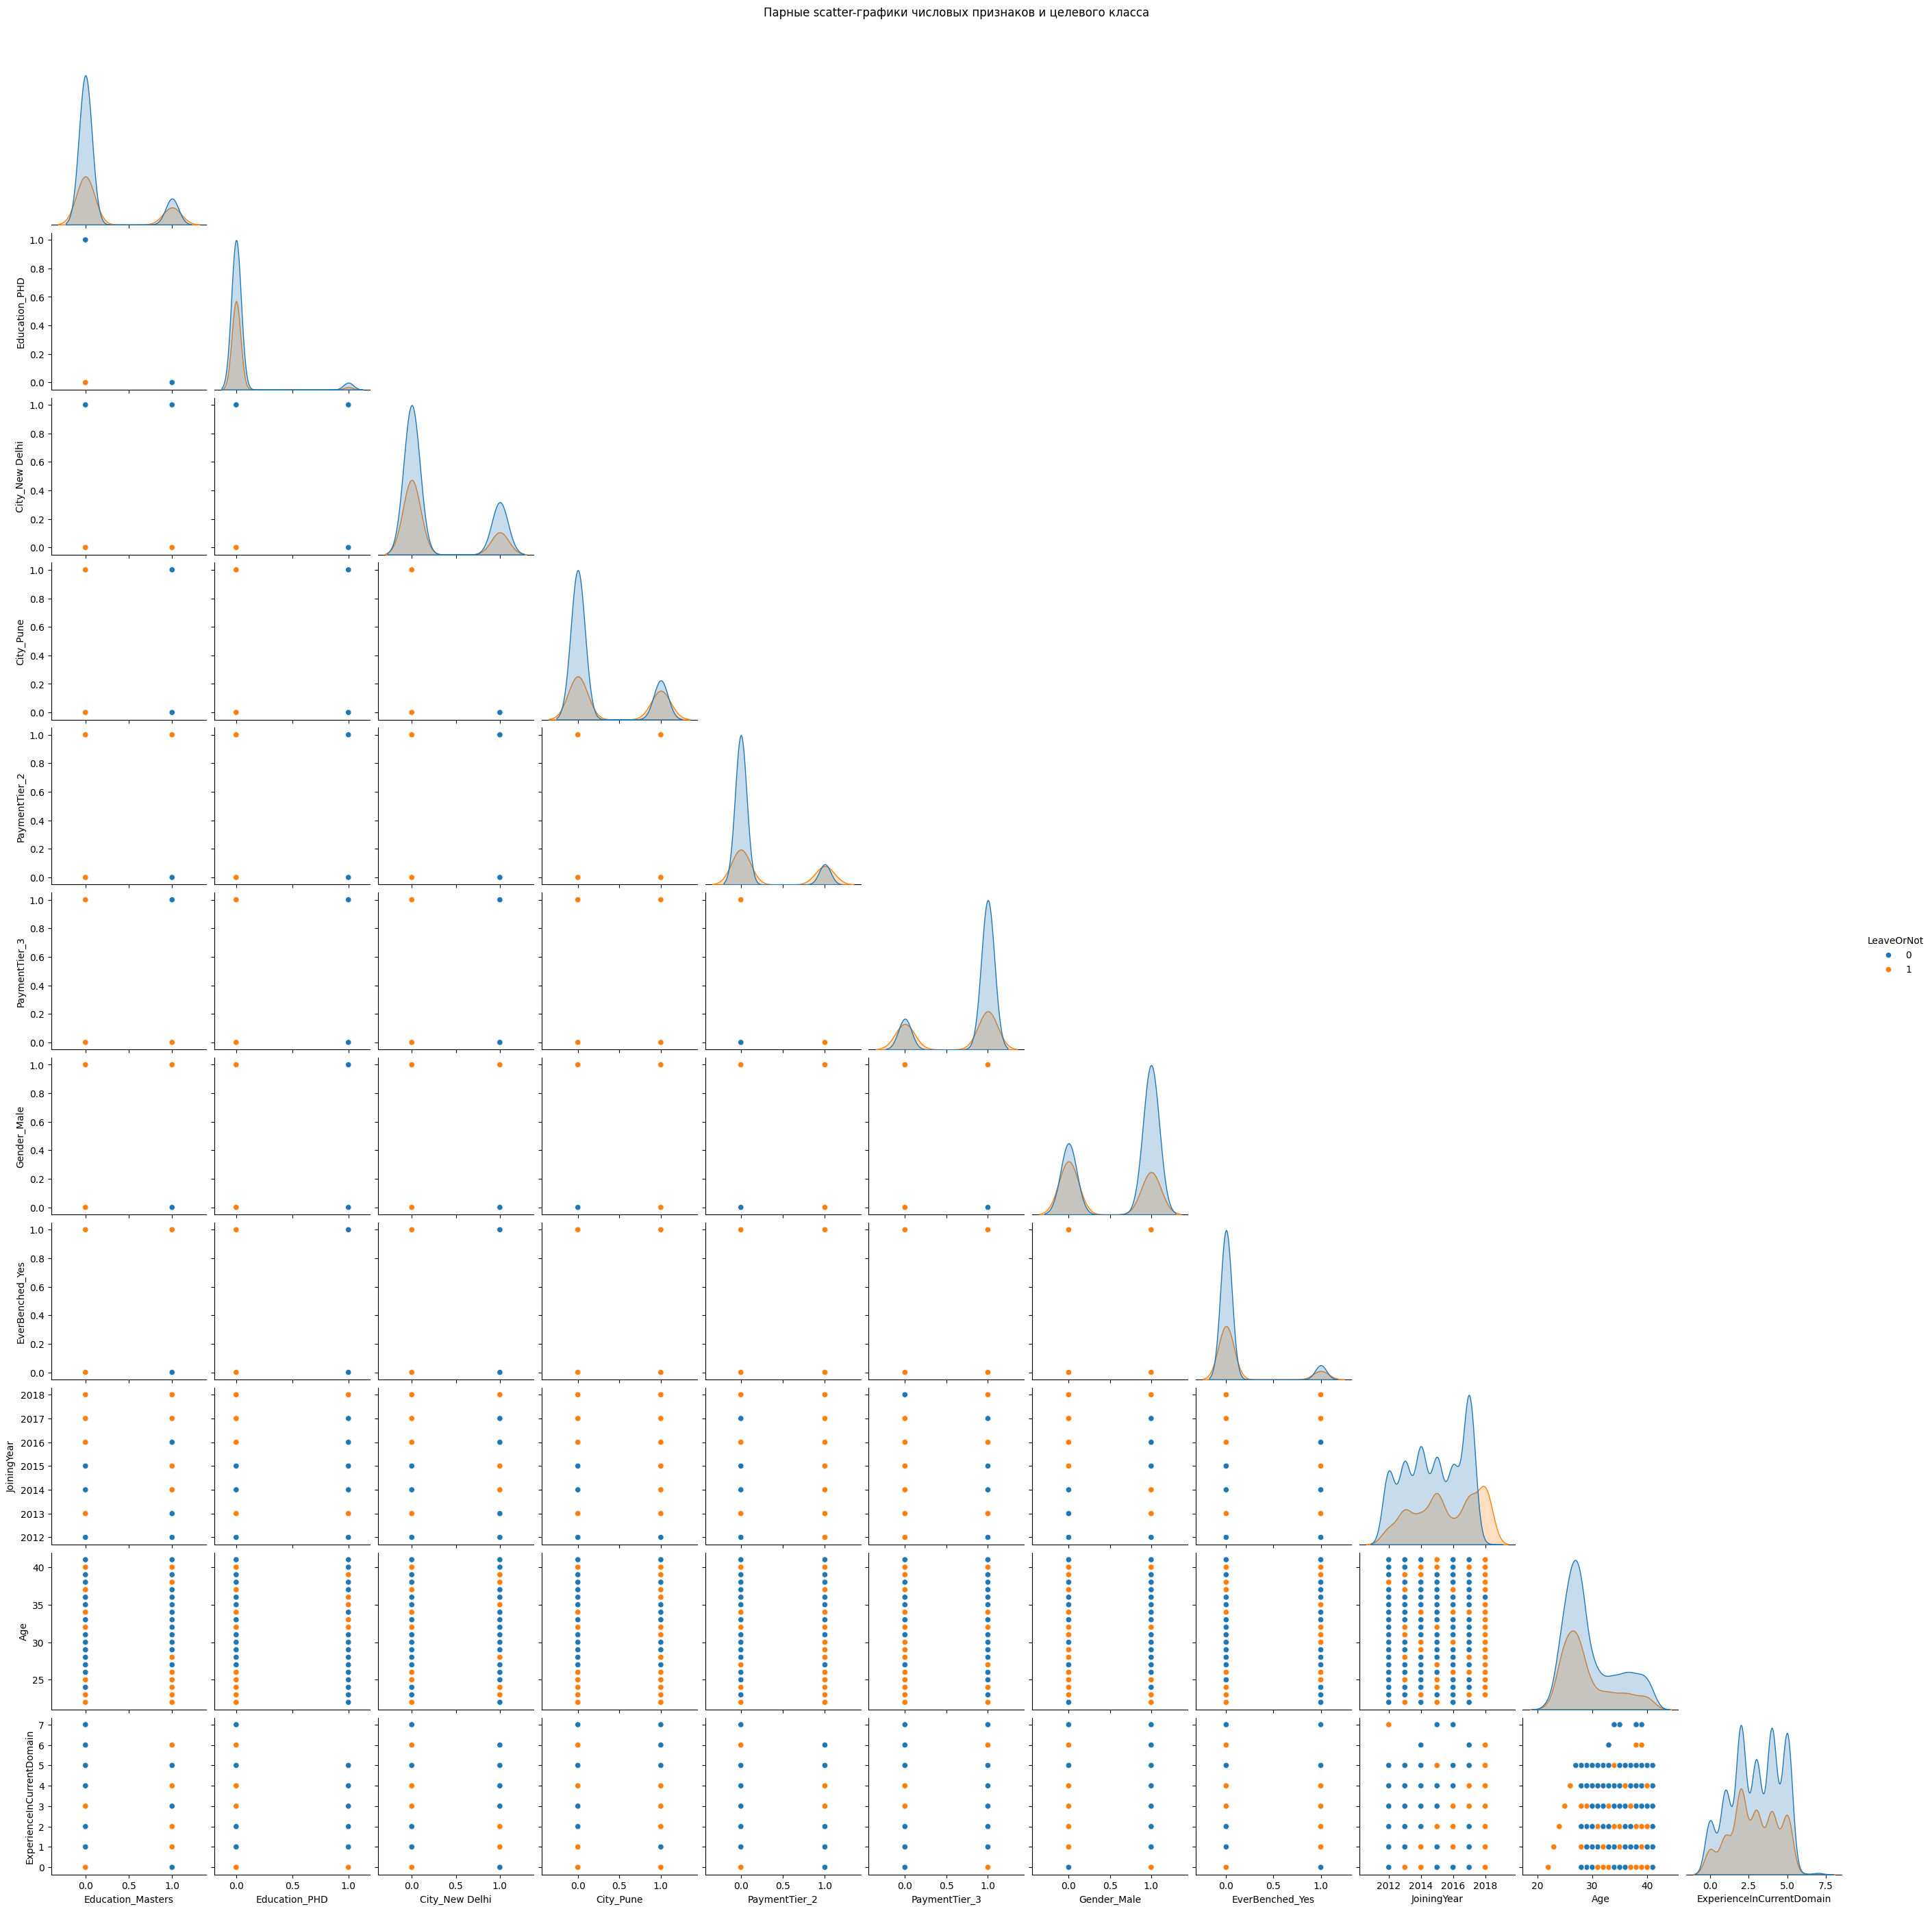

In [13]:
sns.pairplot(df_plot, hue=target, corner=True)
plt.suptitle("Парные scatter-графики числовых признаков и целевого класса", y=1.02)
plt.show()


На графиках boxplot для числовых признаков видно, что в данных отсутствуют выбросы. Но также видно, что числовые признаки имеют разные шкалы, что может негативно сказываться на работе модели.

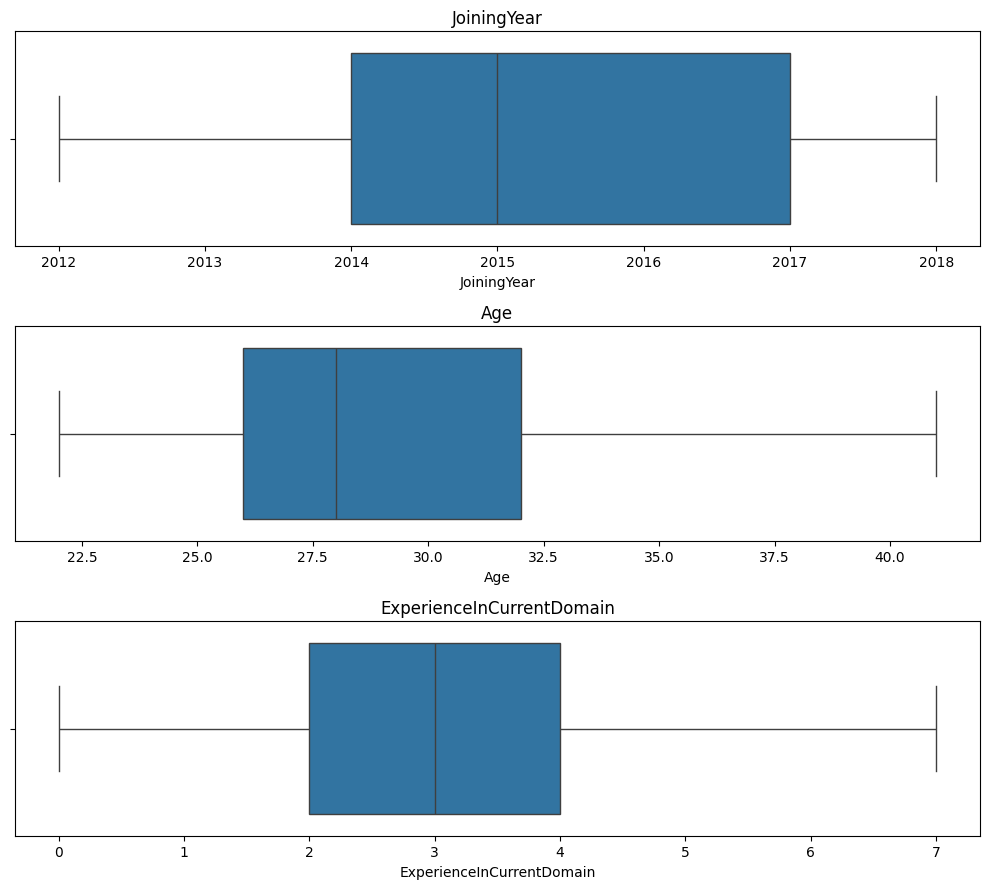

In [14]:
fig, axes = plt.subplots(len(num_cols), 1, figsize=(10, 3 * len(num_cols)))
for ax, col in zip(axes, num_cols):
    sns.boxplot(x=df_plot[col], ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


Для препроцессинга данных на числовых признаках используется StandardScaler, а на категориальных - OneHotEncoder с отбрасыванием первого значения.

Итоговый пайплайн включает в себя препроцессинг, отбор наиболее значимых признаков и KNN.

In [15]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

improved = Pipeline([
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=f_classif, k=10)),
    ("knn", KNeighborsClassifier())
])

Для подбора гиперпараметров используется поиск по сетке с кросс валидацией. Фолды для кросс-валидации выбираются с сохранением баланса таргета.

In [16]:
param_grid = {
    "knn__n_neighbors": [3, 5, 7, 11, 15, 20],
    "knn__p": [1, 2],
    "knn__weights": ["uniform", "distance"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True)

gs = GridSearchCV(
    improved, param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1
)

gs.fit(X_train, y_train)
gs.best_params_

{'knn__n_neighbors': 15, 'knn__p': 1, 'knn__weights': 'uniform'}

Оценка предсказания лучшей модели на тестовой выборке

In [17]:
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

improved_metrics = evaluate_classification(y_test, y_pred, y_proba)
improved_metrics

{'accuracy': 0.8281417830290011,
 'precision': 0.8478260869565217,
 'recall': 0.609375,
 'f1': 0.7090909090909091,
 'roc_auc': 0.8520841857610474}

Матрица ошибок

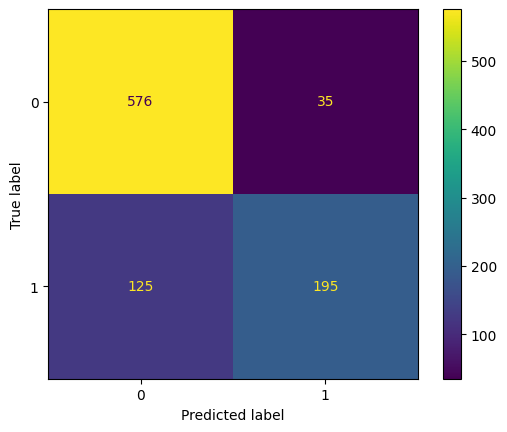

In [18]:
display_confusion_matrix(y_test, y_pred)

Функция для сравнения различных моделей по ментрикам.

In [19]:
def compare_metrics(metrics_df):
    df_melted = metrics_df.reset_index().melt(id_vars='index', var_name='model', value_name='score')

    sns.barplot(data=df_melted, x='index', y='score', hue='model')
    plt.title("Сравнение метрик")
    plt.ylabel("Score")
    plt.xlabel("Метрика")
    plt.legend(title="Модель")
    plt.tight_layout()
    plt.show()

Сравнение бейзлайна и улучшенной модели

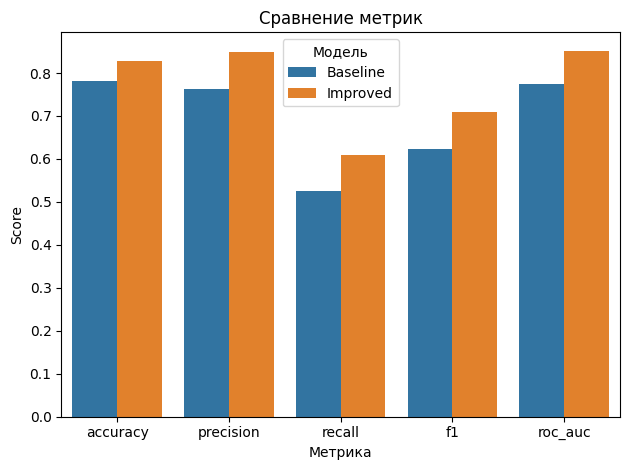

In [20]:
comparison_sklearn = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Improved": improved_metrics
})

compare_metrics(comparison_sklearn)

### Имплементация алгоритма KNN

In [21]:
class CustomKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, n_neighbors=5, p=2, weights="uniform"):
        self.n_neighbors = n_neighbors
        self.p = p
        self.weights = weights

    def fit(self, X, y):
        self.X_ = np.asarray(X)
        self.y_ = np.asarray(y).astype(int)
        return self

    def _distance(self, X):
        X = np.asarray(X)
        dists = np.sum(
            np.abs(X[:, None, :] - self.X_[None, :, :]) ** self.p,
            axis=2
        ) ** (1 / self.p)
        return dists

    def predict_proba(self, X):
        X = np.asarray(X)
        dists = self._distance(X)
        idx = np.argsort(dists, axis=1)[:, :self.n_neighbors]
        neighbors_y = self.y_[idx]
        if self.weights == "uniform":
            proba_pos = neighbors_y.mean(axis=1)
        elif self.weights == "distance":
            k_dists = np.take_along_axis(dists, idx, axis=1)
            w = 1 / (k_dists + 1e-8)
            proba_pos = np.sum(w * neighbors_y, axis=1) / np.sum(w, axis=1)
        else:
            raise ValueError("Invalid weights")
        proba = np.column_stack([1 - proba_pos, proba_pos])
        return proba

    def predict(self, X):
        return (self.predict_proba(X)[:, 1] >= 0.5).astype(int)

Обучение собственной модели на неподготовленных данных и вычисление метрик на тестовых данных.

In [22]:
encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", "passthrough", num_cols)
])

custom_base = Pipeline([
    ("preprocess", encoder),
    ("knn", CustomKNeighborsClassifier())
])

custom_base.fit(X_train, y_train)

y_pred = custom_base.predict(X_test)
y_proba = custom_base.predict_proba(X_test)[:, 1]

custom_base_metrics = evaluate_classification(y_test, y_pred, y_proba)
custom_base_metrics

{'accuracy': 0.7744360902255639,
 'precision': 0.7412280701754386,
 'recall': 0.528125,
 'f1': 0.6167883211678832,
 'roc_auc': 0.7736088379705401}

Матрица ошибок

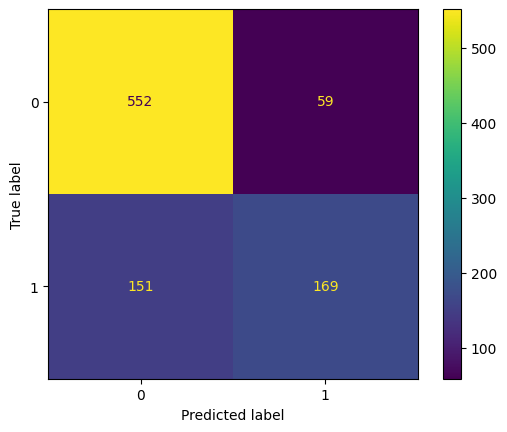

In [23]:
display_confusion_matrix(y_test, y_pred)

Обучение собственной модели с предобработкой данных и выбором лучших параметров.

In [24]:
preprocessor = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(drop="first"), cat_cols)
])

custom_improved = Pipeline([
    ("preprocess", preprocessor),
    ("select", SelectKBest(score_func=f_classif, k=10)),
    ("knn", CustomKNeighborsClassifier(
        n_neighbors=gs.best_params_["knn__n_neighbors"],
        p=gs.best_params_["knn__p"],
        weights=gs.best_params_["knn__weights"]
    ))
])

custom_improved.fit(X_train, y_train)

y_pred = custom_improved.predict(X_test)
y_proba = custom_improved.predict_proba(X_test)[:, 1]

custom_improved_metrics = evaluate_classification(y_test, y_pred, y_proba)
custom_improved_metrics

{'accuracy': 0.8313641245972073,
 'precision': 0.8558951965065502,
 'recall': 0.6125,
 'f1': 0.7140255009107468,
 'roc_auc': 0.851746624386252}

Матрица ошибок

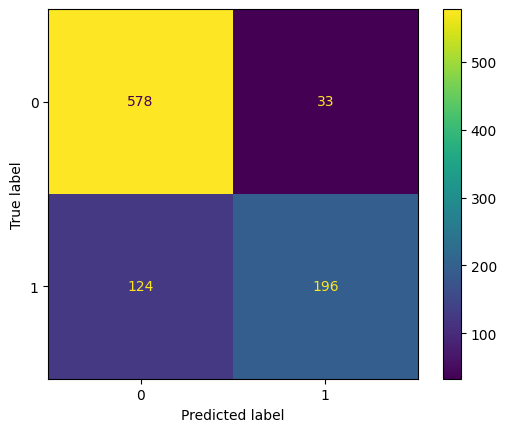

In [25]:
display_confusion_matrix(y_test, y_pred)

Итоговое сравнение всех моделей

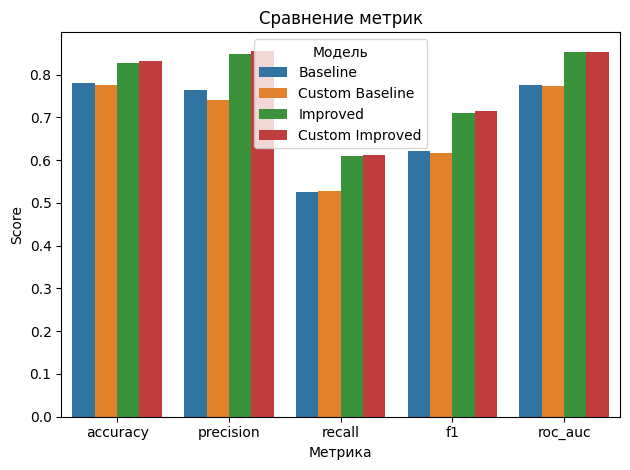

In [26]:
results = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Custom Baseline": custom_base_metrics,
    "Improved": improved_metrics,
    "Custom Improved": custom_improved_metrics
})

compare_metrics(results)

Выводы: 
1. На графиках видно, что лучшие значения по метрикам демонстрируют модели с подбором оптимальных параметров, более эффективной предобработкой данных и отбором наиболее важных признаков.
2. Видно, что собственная имплементация по метрикам практически не отличается от реализации в Sklearn, значит алгоритм реализован верно. 

## Часть 2: Регрессия

Импорт библиотек для регрессии

In [27]:
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_absolute_error, 
    mean_squared_error, 
    root_mean_squared_error, 
    r2_score, 
    mean_absolute_percentage_error
)
from sklearn.preprocessing import TargetEncoder
from sklearn.model_selection import KFold

Чтение данных для регрессии

In [28]:
df = pd.read_csv("./datasets/calories.csv")
df.head()

,User_ID,Gender,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,14733363,male,68,190.0,94.0,29.0,105.0,40.8,231.0
1,14861698,female,20,166.0,60.0,14.0,94.0,40.3,66.0
2,11179863,male,69,179.0,79.0,5.0,88.0,38.7,26.0
3,16180408,female,34,179.0,71.0,13.0,100.0,40.5,71.0
4,17771927,female,27,154.0,58.0,10.0,81.0,39.8,35.0


Просмотр типов признаков и поиск пропущенных значений.

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   User_ID     15000 non-null  int64  
 1   Gender      15000 non-null  object 
 2   Age         15000 non-null  int64  
 3   Height      15000 non-null  float64
 4   Weight      15000 non-null  float64
 5   Duration    15000 non-null  float64
 6   Heart_Rate  15000 non-null  float64
 7   Body_Temp   15000 non-null  float64
 8   Calories    15000 non-null  float64
dtypes: float64(6), int64(2), object(1)
memory usage: 1.0+ MB


Описание числовых признаков

In [30]:
df.describe()

,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
count,1.500000e+04,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,1.497736e+07,42.789800,174.465133,74.966867,15.530600,95.518533,40.025453,89.539533
std,2.872851e+06,16.980264,14.258114,15.035657,8.319203,9.583328,0.779230,62.456978
min,1.000116e+07,20.000000,123.000000,36.000000,1.000000,67.000000,37.100000,1.000000
25%,1.247419e+07,28.000000,164.000000,63.000000,8.000000,88.000000,39.600000,35.000000
50%,1.499728e+07,39.000000,175.000000,74.000000,16.000000,96.000000,40.200000,79.000000
75%,1.744928e+07,56.000000,185.000000,87.000000,23.000000,103.000000,40.600000,138.000000
max,1.999965e+07,79.000000,222.000000,132.000000,30.000000,128.000000,41.500000,314.000000


Разбиение выборки на тестовую и тренировочную

In [31]:
target = "Calories"

y = df[target]
X = df.drop(columns=[target])

num_cols = ["User_ID", "Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]
cat_cols = ["Gender"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2
)

Функция вычисления метрик регрессии. 

В качестве основной метрики я использую MAPE. Эта метрика является наиболее наглядной, так как она показывает на сколько процентов модель ошибается относительно реальных значений таргета.

Дополнительно также считаются MAE, RMSE и R2

In [32]:
def evaluate_regression(y_true, y_pred):
    return {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': root_mean_squared_error(y_true, y_pred),
        'R2': r2_score(y_true, y_pred),
        'MAPE': mean_absolute_percentage_error(y_true, y_pred) * 100
    }

### Бейзлайн

Пол кодируется с помощью OrdinalEncoder, остальные признаки остаются без изменений. После предобработки применяется KNN.

In [33]:
encoder = ColumnTransformer(
    [("cat", OrdinalEncoder(), cat_cols)],
    remainder="passthrough"
)

base = Pipeline([
    ("preprocess", encoder),
    ("knn", KNeighborsRegressor())
])

base.fit(X_train, y_train)

y_pred = base.predict(X_test)

baseline_metrics = evaluate_regression(y_test, y_pred)
baseline_metrics

{'MAE': 56.9292,
 'RMSE': 68.48322617011166,
 'R2': -0.21736123121802198,
 'MAPE': 208.10038471294044}

### Улучшение бейзлайна

Для начала закодируем пол с помощью OrdinalEncoder, так как в этом признаке только 2 значения. И посмотрим на полученные данные.

In [34]:
encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", "passthrough", num_cols)
])

X_train_enc = encoder.fit_transform(X_train)

ohe = encoder.named_transformers_["cat"]
ohe_cols = ohe.get_feature_names_out(cat_cols)
all_cols = list(ohe_cols) + num_cols

df_plot = pd.DataFrame(X_train_enc, columns=all_cols, index=X_train.index)
df_plot[target] = y_train
df_plot.head()

,Gender,User_ID,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
4514,0.0,11565892.0,20.0,165.0,63.0,23.0,111.0,40.7,149.0
6032,0.0,18542385.0,59.0,175.0,73.0,10.0,86.0,39.9,44.0
12745,1.0,11152314.0,33.0,206.0,101.0,17.0,89.0,40.4,68.0
10352,0.0,19297597.0,20.0,163.0,56.0,7.0,79.0,39.4,22.0
8063,0.0,19893884.0,59.0,178.0,71.0,23.0,113.0,40.5,167.0


Посмотрим на матрицу корреляций. По ней видно, что есть признаки, которые сильно коррелируют с таргетом.

Сильнее всего с количеством сброшенных каллорий коррелируют длительность тренировки, сердцебиение и температура тела, также есть слабая корреляция с возрастом.

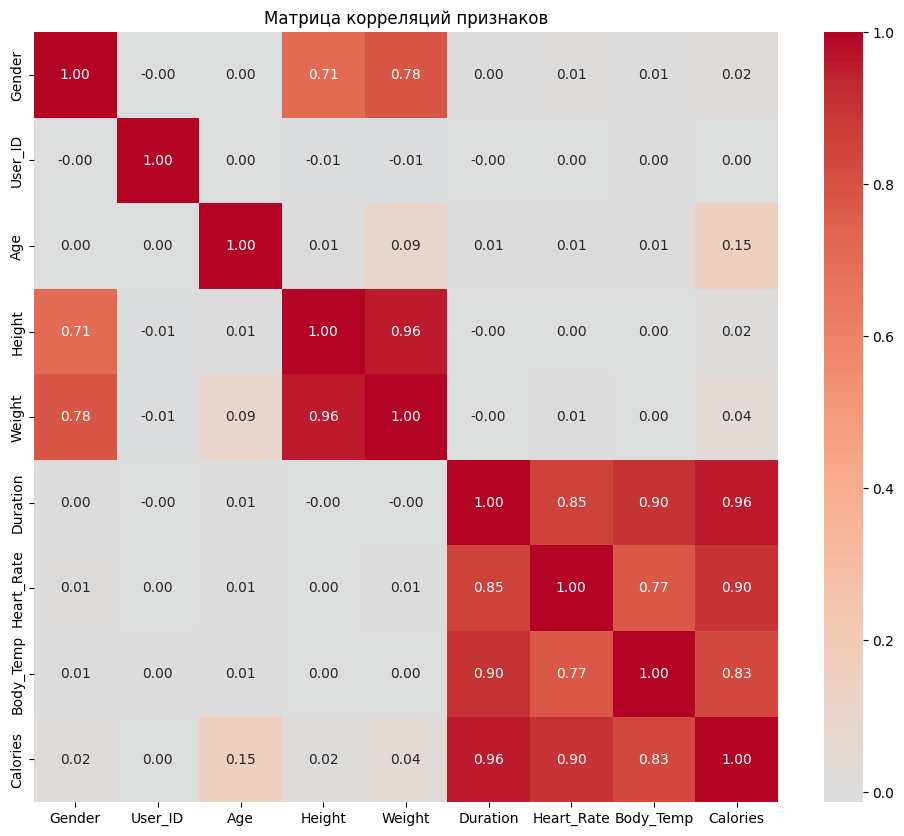

In [35]:
corr = df_plot.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Матрица корреляций признаков")
plt.show()

Посмотрим на гистограммы распределения признаков и таргета, а также на парные scatter-графики

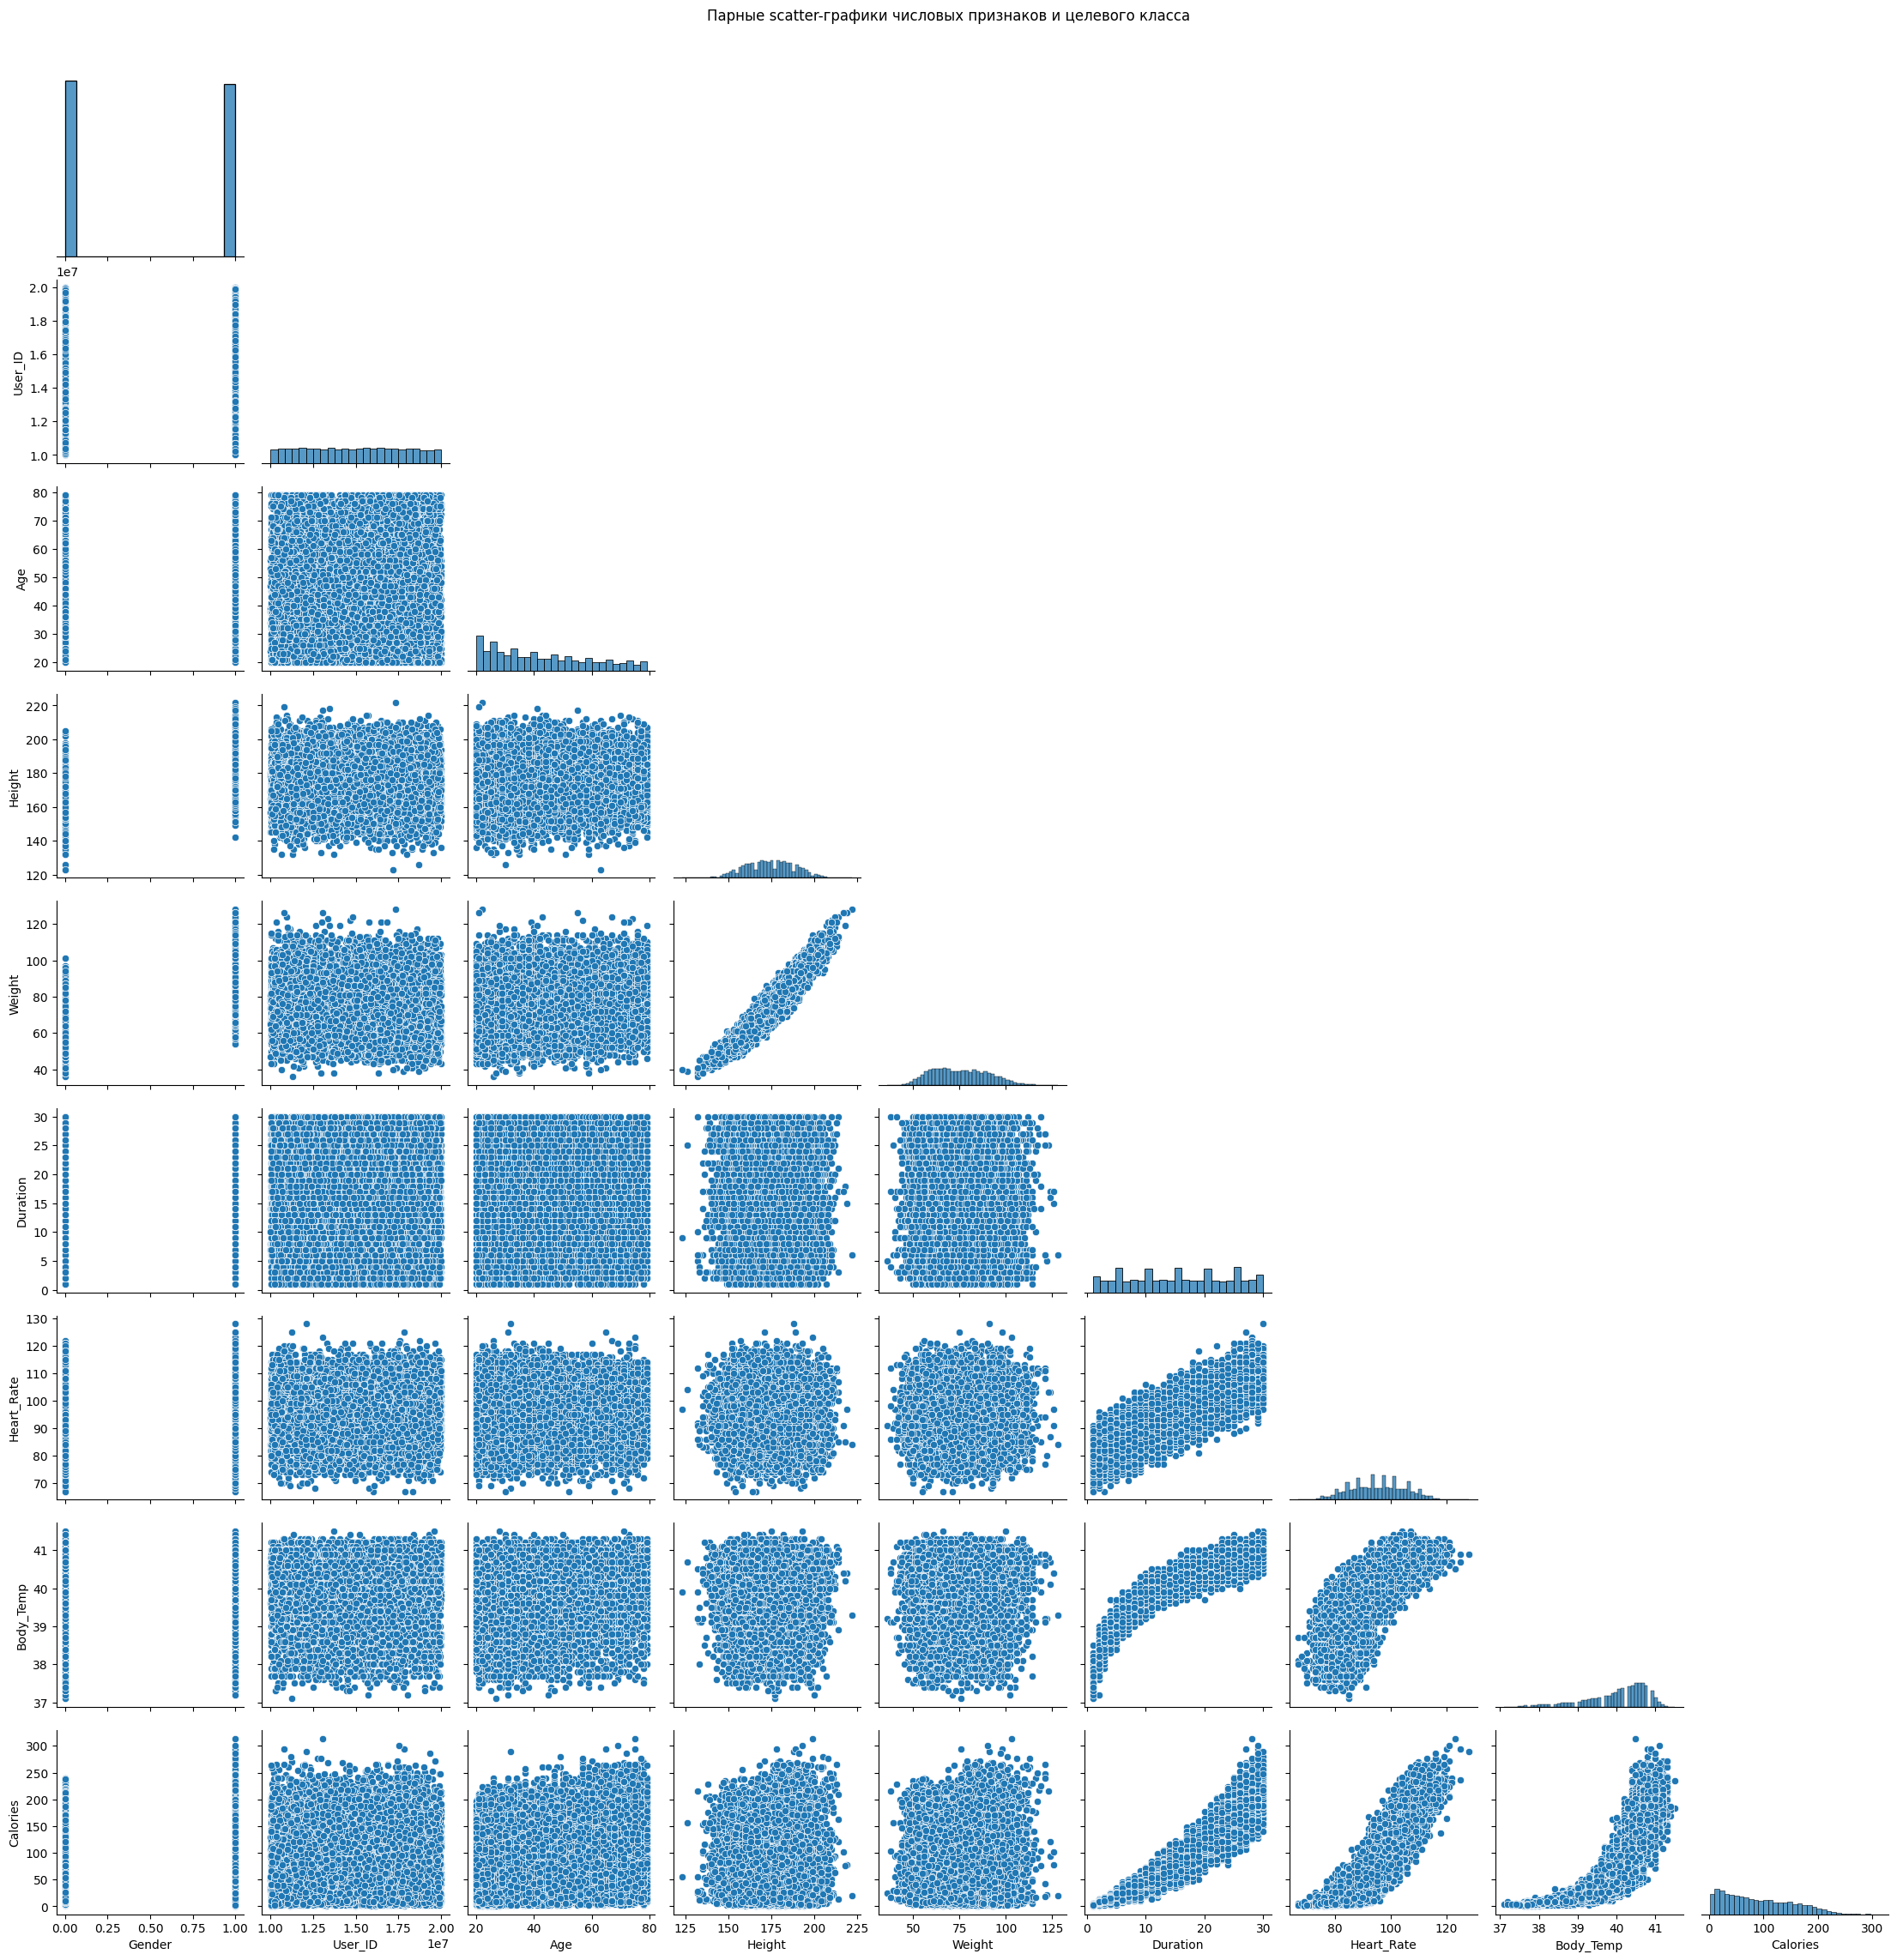

In [36]:
sns.pairplot(df_plot, corner=True)
plt.suptitle("Парные scatter-графики числовых признаков и целевого класса", y=1.02)
plt.show()


Так как все значения в признаке User_ID уникальные, этот признак можно отбросить.

In [37]:
df["User_ID"].nunique()

15000

Препроцессинг данных.

Пол кодируется с помощью OrdinalEncoder, а к числовым признакам применяется StandardScaler.

In [38]:
num_cols_drop_id = ["Age", "Height", "Weight", "Duration", "Heart_Rate", "Body_Temp"]

encoder = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", StandardScaler(), num_cols_drop_id)
])

improved = Pipeline([
    ("preprocess", encoder),
    ("knn", KNeighborsRegressor())
])


Для подбора гиперпараметров используется поиск по сетке с кросс-валидацией на 5 фолдах.

In [39]:

param_grid = {
    "knn__n_neighbors": [3, 5, 7, 11, 15, 20],
    "knn__p": [1, 2],
    "knn__weights": ["uniform", "distance"]
}

cv = KFold(n_splits=5, shuffle=True)

gs = GridSearchCV(
    improved, 
    param_grid,
    cv=cv,
    scoring="neg_mean_absolute_percentage_error",
    n_jobs=-1
)

gs.fit(X_train, y_train)
gs.best_params_

{'knn__n_neighbors': 11, 'knn__p': 1, 'knn__weights': 'distance'}

Оценка улучшенной модели

In [40]:
best_model = gs.best_estimator_

y_pred = best_model.predict(X_test)

improved_metrics = evaluate_regression(y_test, y_pred)
improved_metrics

{'MAE': 3.471772128631188,
 'RMSE': 4.761913573555037,
 'R2': 0.9941140839696818,
 'MAPE': 6.7994587191722715}

Сравнение бейзлайна и улучшенной модели

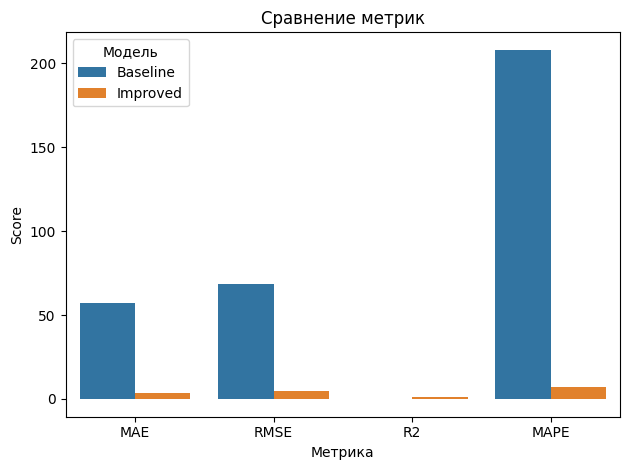

In [41]:
comparison_sklearn = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Improved": improved_metrics
})
compare_metrics(comparison_sklearn)

### Имплементация алгоритма KNN

In [42]:
class CustomKNeighborsRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, n_neighbors=5, p=2, weights="uniform"):
        self.n_neighbors = n_neighbors
        self.p = p
        self.weights = weights
    
    def fit(self, X, y):
        self.X_ = np.asarray(X)
        self.y_ = np.asarray(y)
        return self

    def _distance(self, X):
        X = np.asarray(X)
        dists = np.sum(
            np.abs(X[:, None, :] - self.X_[None, :, :]) ** self.p,
            axis=2
        ) ** (1 / self.p)
        return dists

    def predict(self, X):
        X = np.asarray(X)
        dists = self._distance(X)
        idx = np.argsort(dists, axis=1)[:, :self.n_neighbors]
        neighbors_y = self.y_[idx]
        if self.weights == "uniform":
            return neighbors_y.mean(axis=1)
        elif self.weights == "distance":
            k_dists = np.take_along_axis(dists, idx, axis=1)
            w = 1 / (k_dists + 1e-8)
            return np.sum(w * neighbors_y, axis=1) / np.sum(w, axis=1)
        else:
            raise ValueError("Invalid weights")


Обучение собственной модели на неподготовленных данных

In [43]:
encoder = ColumnTransformer(
    [("cat", OrdinalEncoder(), cat_cols)],
    remainder="passthrough"
)

custom_base = Pipeline([
    ("preprocess", encoder),
    ("knn", CustomKNeighborsRegressor())
])

custom_base.fit(X_train, y_train)

y_pred = custom_base.predict(X_test)

custom_base_metrics = evaluate_regression(y_test, y_pred)
custom_base_metrics

{'MAE': 56.9292,
 'RMSE': 68.48322617011166,
 'R2': -0.21736123121802198,
 'MAPE': 208.10038471294044}

Обучение собственной модели с улучшениями

In [44]:
preprocessor = ColumnTransformer([
    ("cat", OrdinalEncoder(), cat_cols),
    ("num", StandardScaler(), num_cols_drop_id)
])

custom_improved = Pipeline([
    ("preprocess", preprocessor),
    ("knn", CustomKNeighborsRegressor(
        n_neighbors=gs.best_params_["knn__n_neighbors"],
        p=gs.best_params_["knn__p"],
        weights=gs.best_params_["knn__weights"]
    ))
])

custom_improved.fit(X_train, y_train)

y_pred = custom_improved.predict(X_test)

custom_improved_metrics = evaluate_regression(y_test, y_pred)
custom_improved_metrics

{'MAE': 3.4717721304631812,
 'RMSE': 4.761913575790394,
 'R2': 0.9941140839641559,
 'MAPE': 6.799458722287843}

Итоговое сравнение всех моделей

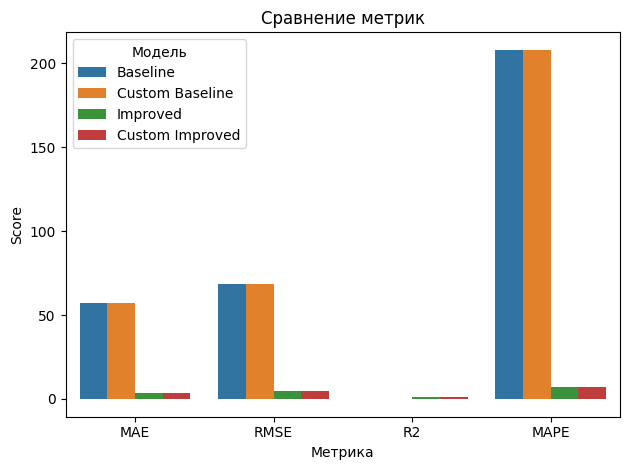

In [45]:
results = pd.DataFrame({
    "Baseline": baseline_metrics,
    "Custom Baseline": custom_base_metrics,
    "Improved": improved_metrics,
    "Custom Improved": custom_improved_metrics
})

compare_metrics(results)

Выводы: 
1. Модель без улучшений неспособна дать нормальный результат, так как она использует признак User_ID, а все пользователи в наборе данных уникальные.
2. Лучшие результаты продемонстрировали модели, которые использовали оптимальные гиперпараметры и применялись после масштабирования признаков.
2. Собственная реализация KNN показала результаты, близкие к sklearn, что подтверждает корректность реализации.